# Gradient-descent-based optimization

In [1]:
import importlib
from functools import partial
from typing import Callable
from urllib.request import urlopen

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax
from jax import jit, lax, value_and_grad, vmap
from jaxtyping import Array
from sbmltoodejax.modulegeneration import GenerateModel
from sbmltoodejax.parse import ParseSBMLFile

jax.config.update("jax_platform_name", "cpu")

/home/mayalen/miniconda3/envs/grn/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


## Utils 

In [2]:
def generate_model(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):

    model_jax_file = "jax_model.py"
    model_url = f"https://www.ebi.ac.uk/biomodels/model/download/BIOMD{model_idx:010d}.2?filename=BIOMD{model_idx:010d}_url.xml"
    with urlopen(model_url) as response:
        model_xml_body = response.read().decode("utf-8")
    model_data = ParseSBMLFile(model_xml_body)
    GenerateModel(
        model_data,
        model_jax_file,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    return model_jax_file


def load_modelstepfunc(
    model_idx,
    deltaT=0.1,
    atol=1e-6,
    rtol=1e-12,
    vmap_over_reactions=False,
):
    model_jax_filepath = generate_model(
        model_idx,
        deltaT=deltaT,
        atol=atol,
        rtol=rtol,
        vmap_over_reactions=vmap_over_reactions,
    )
    spec = importlib.util.spec_from_file_location("JaxModelSpec", model_jax_filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    modelstepfunc_cls = getattr(module, "ModelStep")
    modelstepfunc = modelstepfunc_cls(atol=atol, rtol=rtol)
    y0 = getattr(module, "y0")
    w0 = getattr(module, "w0")
    c = getattr(module, "c")

    return modelstepfunc, y0, w0, c

In [3]:
def plot_time_trajectories(times, ys, y_ids, y_labels):
    plt.figure(figsize=(10, 7))
    for y_idx, y_label in zip(y_ids, y_labels):
        plt.plot(times, ys[y_idx], label=y_label)
    plt.legend()
    plt.show()

    return

In [4]:
def plot_batched_time_trajectories(times, ys, y_ids, y_labels):

    plt.figure(figsize=(10, 7))
    for y_idx, y_label in zip(y_ids, y_labels):
        mean_curve = ys[:, y_idx, :].mean(0)
        std_curve = ys[:, y_idx, :].std(0)
        plt.plot(times, mean_curve, label=y_label)
        plt.fill_between(
            times, mean_curve - std_curve, mean_curve + std_curve, alpha=0.5
        )
    plt.legend()
    plt.show()

    return

### GRN wrapper module

In [5]:
class GRNRollout:
    n_steps: int = eqx.static_field()
    deltaT: float = eqx.static_field()
    y0: Array
    w0: Array
    c: Array
    t0: float = eqx.static_field()
    grn_step: eqx.Module

    def __init__(
        self,
        n_steps,
        y0,
        w0,
        c,
        t0,
        deltaT,
        grn_step,
    ):
        self.n_steps = n_steps
        self.y0 = y0
        self.w0 = w0
        self.c = c
        self.t0 = t0
        self.deltaT = deltaT

        self.grn_step = grn_step

    def __call__(self, intervention_fn, intervention_params):
        @jit
        def f(carry, x):
            (y, w, c, t) = carry

            # make grn step
            y, w, c, t = self.grn_step(y, w, c, t, self.deltaT)

            # apply intervention
            y, w, c = intervention_fn(y, w, c, t, intervention_params)

            return (y, w, c, t), (y, w)

        (y, w, c, t), (ys, ws) = lax.scan(
            f, (self.y0, self.w0, self.c, self.t0), jnp.arange(self.n_steps)
        )
        ys = jnp.moveaxis(ys, 0, -1)
        ws = jnp.moveaxis(ws, 0, -1)
        times = jnp.arange(0, 0 + self.n_steps * self.deltaT, self.deltaT)

        return ys, ws, times

### Intervention as parametrized functions

In [6]:
class NullIntervention(eqx.Module):
    @jit
    def __call__(self, y, w, c, t, intervention_params):
        return y, w, c

In [7]:
class SinusoidIntervention(eqx.Module):
    controlled_y_idx: int = eqx.static_field()

    def __init__(self, controlled_y_idx):
        self.controlled_y_idx = controlled_y_idx

    @jit
    def __call__(self, y, w, c, t, intervention_params):
        y = y.at[self.controlled_y_idx].set(
            intervention_params["A"]
            * jnp.sin(
                2 * jnp.pi * intervention_params["f"] * t + intervention_params["phi"]
            )
            + intervention_params["b"]
        )
        return y, w, c

In [8]:
class PiecewiseIntervention(eqx.Module):
    time_to_interval_fn: Callable
    null_intervention: eqx.Module

    def __init__(self, time_to_interval_fn):
        """
        Piecewise Intervention
        Parameters:
            - time_to_interval is a function that takes t: secs as input and returns the interval: Array[int] as output.
        """
        self.time_to_interval_fn = time_to_interval_fn
        self.null_intervention = NullIntervention()

    @jit
    def __call__(self, y, w, c, t, intervention_params):
        """
        If time_to_interval_fn(t) returns empty array or a [-1] array, apply NullIntervention else apply intervention on corresponding interval
        """
        interval_idx = self.time_to_interval_fn(t)
        # ([]+1).sum() = 0 whereas ([uint]+1).sum()=uint+1>0
        return lax.cond(
            (interval_idx + 1).sum() > 0,
            self.apply,
            self.null_intervention,
            y,
            w,
            c,
            intervention_params,
            interval_idx,
        )

    @jit
    def apply(self, y, w, c, intervention_params, interval_idx):
        raise NotImplementedError


class PiecewiseSetConstantIntervention(PiecewiseIntervention):
    def apply(self, y, w, c, intervention_params, interval_idx):
        for y_idx, new_val in intervention_params.items():
            y = y.at[..., y_idx].set(new_val[..., interval_idx])

        return y, w, c

### Optimization utils

In [9]:
def target_r(x):
    return jnp.sin(2 * x - jnp.pi / 2.0) + 1

In [10]:
@eqx.filter_jit
def grad_loss(intervention_params, grn_rollout):
    ys, ws, times = grn_rollout(intervention_params=intervention_params)
    loss = jnp.square(ys[2] - target_r(times)).sum()
    return loss


@eqx.filter_jit
def make_step(intervention_params, grn_rollout, opt_state):
    loss, grads = value_and_grad(grad_loss)(intervention_params, grn_rollout)
    updates, opt_state = optim.update(grads, opt_state)
    intervention_params = optax.apply_updates(intervention_params, updates)
    return loss, intervention_params, opt_state

## Optimizing for a target Pattern

### Case 1: Sinusoid Intervention

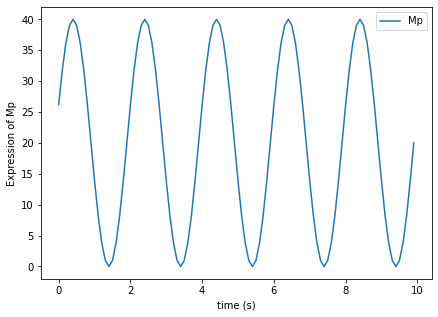

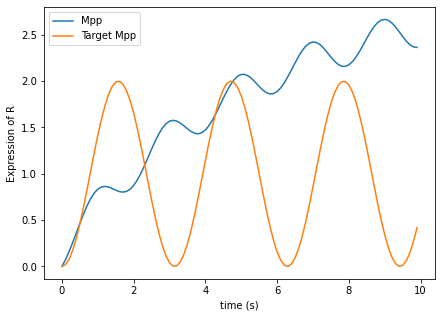

In [11]:
figsize = (7, 5)
n_steps = 100
t0 = 0.0
deltaT = 0.1
modelstepfunc, y0, w0, c = load_modelstepfunc(31)
grn_rollout = GRNRollout(n_steps, y0, w0, c, t0, deltaT, modelstepfunc)
grn_rollout = partial(grn_rollout, intervention_fn=SinusoidIntervention(1))

intervention_params = {
    "A": 20.0,
    "f": 0.5,
    "phi": 0.0,
    "b": 20.0,
}

ys, ws, times = grn_rollout(intervention_params=intervention_params)

plt.figure(figsize=figsize)
plt.plot(times, ys[1, :], label="Mp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of Mp")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    times,
    ys[2, :],
    label="Mpp",
)
plt.plot(times, target_r(times), label=f"Target Mpp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of R")
plt.show()

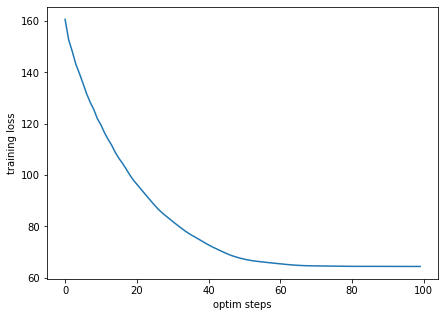

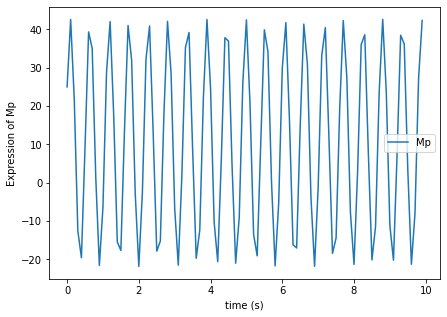

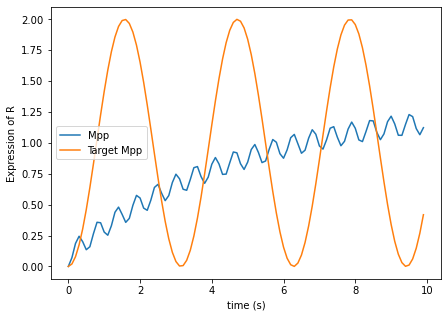

In [12]:
n_optim_steps = 100
optim = optax.adam(0.2)
opt_state = optim.init(intervention_params)
train_loss = []
for optim_step_idx in range(n_optim_steps):
    loss, intervention_params, opt_state = make_step(
        intervention_params, grn_rollout, opt_state
    )
    train_loss.append(loss)

plt.figure(figsize=figsize)
plt.plot(jnp.arange(n_optim_steps), train_loss)
plt.xlabel("optim steps")
plt.ylabel("training loss")
plt.show()

ys, ws, times = grn_rollout(intervention_params=intervention_params)

plt.figure(figsize=figsize)
plt.plot(times, ys[1, :], label="Mp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of Mp")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    times,
    ys[2, :],
    label="Mpp",
)
plt.plot(times, target_r(times), label=f"Target Mpp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of R")
plt.show()

### Case 2: Free Intervention

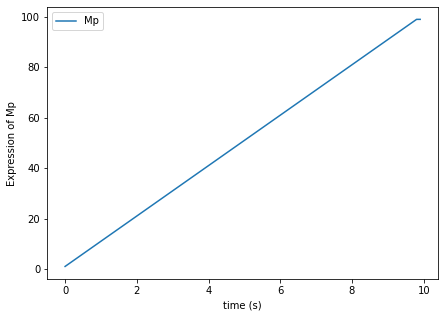

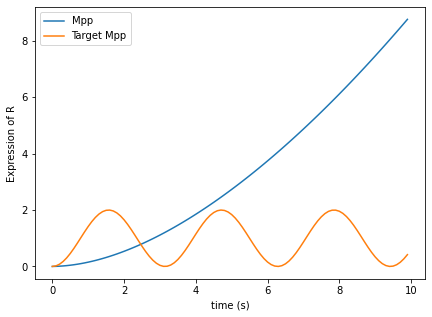

In [13]:
n_steps = 100
t0 = 0.0
deltaT = 0.1
modelstepfunc, y0, w0, c = load_modelstepfunc(31)
grn_rollout = GRNRollout(n_steps, y0, w0, c, t0, deltaT, modelstepfunc)


class time_to_interval_fn(eqx.Module):
    time_vals: Array

    def __call__(self, t):
        return jnp.where((t - self.time_vals) < deltaT / 10, size=1, fill_value=-1)[0][
            0
        ]


grn_rollout = partial(
    grn_rollout,
    intervention_fn=PiecewiseSetConstantIntervention(
        time_to_interval_fn=time_to_interval_fn(
            time_vals=jnp.arange(0, 0 + (n_steps + 1) * deltaT, deltaT)
        )
    ),
)

intervention_params = {1: 1.0 * jnp.arange(100)}

time_to_interval_fn = time_to_interval_fn(
    time_vals=jnp.arange(0, 0 + n_steps * deltaT, deltaT)
)

# y = y0
# w = w0
# t = 0
# for step_idx in range(n_steps):
#     y, w, c, t = modelstepfunc(y, w, c, t, deltaT)
#     interval_idx = time_to_interval_fn(t)
#     print(
#         t,
#         interval_idx,
#         (interval_idx + 1).sum() > 0,
#         intervention_params[1][..., interval_idx],
#     )


ys, ws, times = grn_rollout(intervention_params=intervention_params)

plt.figure(figsize=figsize)
plt.plot(times, ys[1, :], label="Mp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of Mp")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    times,
    ys[2, :],
    label="Mpp",
)
plt.plot(times, target_r(times), label=f"Target Mpp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of R")
plt.show()

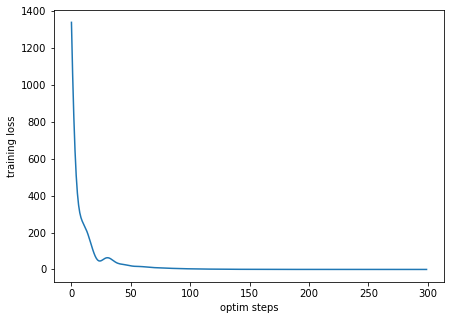

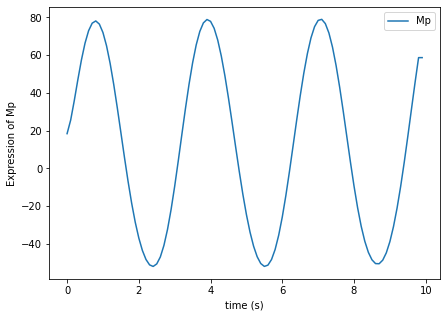

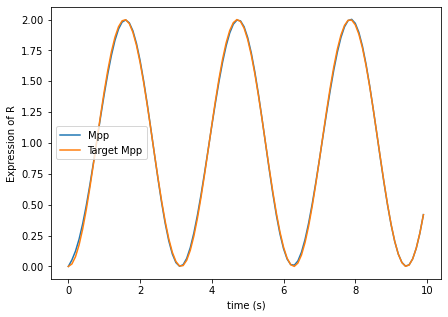

In [14]:
n_optim_steps = 300
optim = optax.adam(5.0)
opt_state = optim.init(intervention_params)
train_loss = []
for optim_step_idx in range(n_optim_steps):
    loss, intervention_params, opt_state = make_step(
        intervention_params, grn_rollout, opt_state
    )
    train_loss.append(loss)

plt.figure(figsize=figsize)
plt.plot(jnp.arange(n_optim_steps), train_loss)
plt.xlabel("optim steps")
plt.ylabel("training loss")
plt.show()

ys, ws, times = grn_rollout(intervention_params=intervention_params)

plt.figure(figsize=figsize)
plt.plot(times, ys[1, :], label="Mp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of Mp")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    times,
    ys[2, :],
    label="Mpp",
)
plt.plot(times, target_r(times), label=f"Target Mpp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("Expression of R")
plt.show()